In [2]:
#import findspark
#findspark.init()
import pyspark
from pyspark.sql import SQLContext 
from pyspark.sql.types import * 
from textblob import TextBlob
from pyspark.sql.functions import rand,lit,udf,trim,length,explode
import numpy as np
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer,IDF,CountVectorizer
from nltk.corpus import stopwords
import re
from pyspark.ml.feature import CountVectorizer, Tokenizer, StopWordsRemover
from pyspark import SparkConf
from pyspark.context import SparkContext
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from nltk.stem.porter import *

In [ ]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [3]:
df = (sqlContext.read.format("csv").options(header="true").option("quote","\"").option("escape","\"").option("multiLine", "true").load("/home/apalisetty1/data/2020-04-14 Coronavirus Tweets.CSV"))
df.createOrReplaceTempView("tweets")

In [4]:
#Get the count of all the tweets
sqlContext.sql("select count(*) as cnt from tweets").show()

+-----+
|  cnt|
+-----+
|17089|
+-----+



In [5]:
df.show(2)

+-------------------+----------+--------------------+------------+--------------------+---------+------------------+----------------+--------------------+--------+----------+----------------+-------------+------------+---------------+----------+---------------+-------------+------------+--------------------+--------+----+
|          status_id|   user_id|          created_at| screen_name|                text|   source|reply_to_status_id|reply_to_user_id|reply_to_screen_name|is_quote|is_retweet|favourites_count|retweet_count|country_code|place_full_name|place_type|followers_count|friends_count|account_lang|  account_created_at|verified|lang|
+-------------------+----------+--------------------+------------+--------------------+---------+------------------+----------------+--------------------+--------+----------+----------------+-------------+------------+---------------+----------+---------------+-------------+------------+--------------------+--------+----+
|1249849852659478528|2722502

In [6]:
#Function to define Subjectivity and Polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [7]:
#Function to label the tweet
def label_data(polarity) :
    if polarity ==0:
        return 0
    elif polarity >0:
        return 1
    elif polarity <0:
        return 2

In [8]:
#Function to clean the tweets
def clean_text(text):
    text=re.sub(r'@[A-Za-z0-9]+','',text).strip() #remove mentions
    text=re.sub(r'#+','',text).strip() #removing #symbol
    text=re.sub(r'RT[\s]+','',text).strip()
    text=re.sub(r'[?|$|.|!|;|:|&|"|,|"|"|*|-|(|)]','',text).strip()
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE).strip()
    text = re.sub(r'  ', ' ', text).strip()
    return text

In [9]:
#Function to Remove Emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [10]:
#Function to Remove Emojis
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [11]:
#Function which call all the texclean, remove emojis,polarity and labels the tweet
def data_preprocess(t1):
    clean_udf_str=udf(lambda z: clean_text(z), StringType())
    df_pre_clean=t1.select(clean_udf_str('text_n').alias('text'))
    emoji_udf_str=udf(lambda z: remove_emoji(z), StringType())
    df_pre_rm_em=df_pre_clean.select(emoji_udf_str('text').alias('text'))
    demo_udf_str=udf(lambda z: deEmojify(z), StringType())
    df_pre_rm_dem=df_pre_rm_em.select(demo_udf_str('text').alias('text'))
    sub_udf_float = udf(lambda z: getSubjectivity(z), FloatType())
    pol_udf_float = udf(lambda z: getPolarity(z), FloatType())
    df_sub_pol=df_pre_rm_dem.select("*",sub_udf_float('text').alias('subjectivity'),pol_udf_float('text').alias('polarity'))
    lab_udf_str=udf(lambda z: label_data(z), IntegerType())
    df_final=df_sub_pol.select("*",lab_udf_str('polarity').alias('label'))
    df_pre_proced=df_final.select("text","label")
    return df_pre_proced

In [12]:
#Function to tokenize and remove the Stopwords
def token_rmstp(df_preprocess):
    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    wordsdata=tokenizer.transform(df_pre_proced)

    #Removing Stop Words
    stop_words_remover = StopWordsRemover(inputCol="words", outputCol="words_cleaned")
    words_rmsw=stop_words_remover.transform(wordsdata)
    return words_rmsw

In [13]:
# Instantiate stemmer object
stemmer = PorterStemmer()
def stemming(text):
    return [stemmer.stem(i) for i in text]

In [14]:
#Function to get the data for NRC plots
nrc_df= (sqlContext.read.format("csv").option("header", "true").load("/home/apalisetty1/data/nrc.csv"))
nrc_df.createOrReplaceTempView("nrc")
def nrc_plots(words_rmsw):
        wrd_exp=words_rmsw.select(explode(words_rmsw.words_cleaned))
        wrd_exp.createOrReplaceTempView("wrd_cnt")
        wrd_cnt=sqlContext.sql("select col,count(*) as cnt from wrd_cnt where length(col) !=0 group by col")
        wrd_cnt.createOrReplaceTempView("wrd_cnt")
        nrc_emt=sqlContext.sql("select n.emotion,count(*) as cnt from wrd_cnt w inner join nrc n on w.col=n.word where n.emotion not in('positive','negative')  and n.association=1 group by n.emotion")
        nrc_emt=nrc_emt.toPandas()
        plt.figure(figsize=(10, 5))
        sns.barplot(x="emotion",y="cnt",palette="deep", data=nrc_emt)

In [15]:
#Create temp views for all the data required for visualization
tweetsDF = sqlContext.sql("SELECT country_code,REPLACE(text,'\n','') as text_n FROM tweets where lang='en' and tweets.country_code='US' ")
tweetsDF_Non = sqlContext.sql("SELECT country_code,REPLACE(text,'\n','') as text_n FROM tweets where  tweets.country_code !='US' ")
tweetsplaceDF = sqlContext.sql("SELECT *,REPLACE(text,'\n',' ') as text_n FROM tweets")
tweetsamountDF = sqlContext.sql("SELECT place_full_name,count(*) as amount FROM tweets group by place_full_name order by amount desc LIMIT 10")
countryamountDF = sqlContext.sql("SELECT country_code,count(*) as amount  FROM tweets where country_code is not null  group by country_code  order by amount desc LIMIT 10")

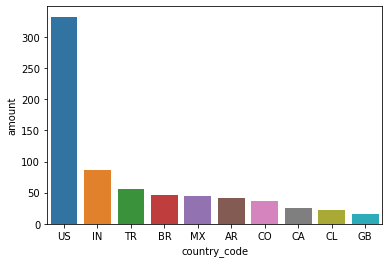

In [16]:
##Country wise tweets Plotting
b = countryamountDF.toPandas()
sns.barplot(x="country_code", y="amount", data=b)

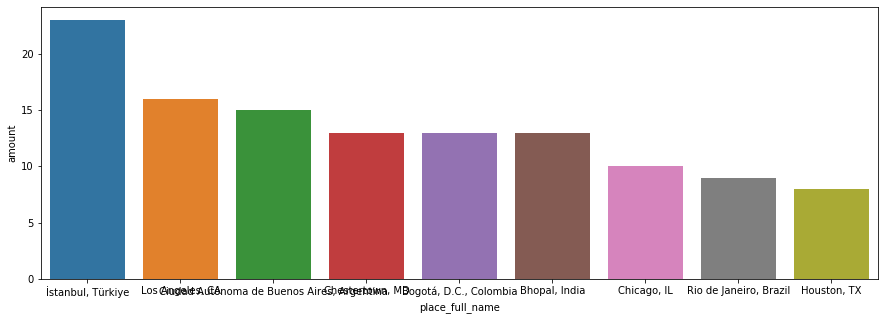

In [17]:
##Places wise tweets Plotting
a = tweetsamountDF.toPandas()
plt.figure(figsize=(15, 5))
sns.barplot(x="place_full_name",y="amount", data=a)

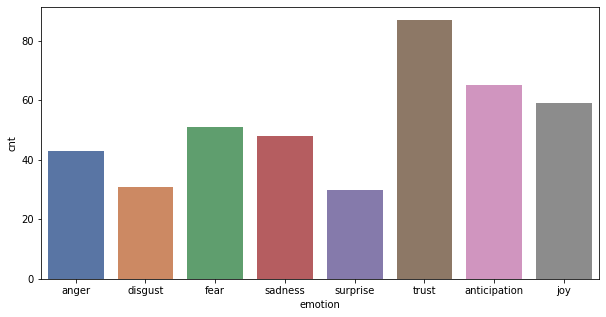

In [18]:
## NRC for US countries
df_pre_proced=data_preprocess(tweetsDF)
words_rmsw=token_rmstp(df_pre_proced)
nrc_plots(words_rmsw)

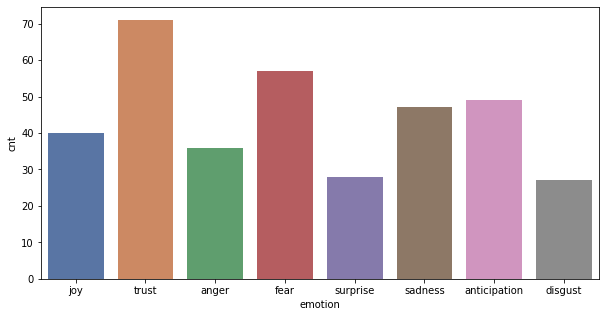

In [19]:
#NRC for Non-US
df_pre_proced=data_preprocess(tweetsDF_Non)
words_rmsw=token_rmstp(df_pre_proced)
nrc_plots(words_rmsw)

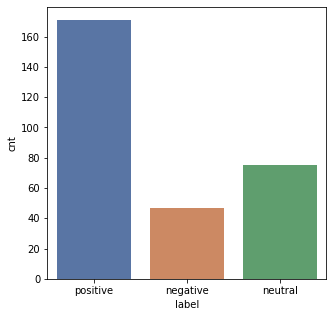

In [20]:
#Polarity Plotting
df_pre_proced=data_preprocess(tweetsDF)
label_viz=df_pre_proced.select("label")
label_viz.createOrReplaceTempView("label_viz")
label_viz=sqlContext.sql("select case when label=1 then 'positive' when label=2 then 'negative' when label=0 then 'neutral' end as label,count(*) as cnt from label_viz group by label")
label_viz=label_viz.toPandas()
plt.figure(figsize=(5, 5))
sns.barplot(x="label",y="cnt",palette="deep", data=label_viz)

In [21]:
#Processing starts here- From the tweetsDF data call the data preprocessing and tokenizing functions
df_pre_proced=data_preprocess(tweetsDF)
words_rmsw=token_rmstp(df_pre_proced)

##Perform Stemming after the above process is done
stem_udf_str=udf(lambda z: stemming(z), ArrayType(StringType()))
df_final_stem=words_rmsw.select('label',stem_udf_str('words_cleaned').alias('words_cleaned'))

In [22]:
## Using TF- IDF Features
hashing_tf = HashingTF(inputCol = "words_cleaned", outputCol = "frequency")
Hashingdata=hashing_tf.transform(words_rmsw)
idf = IDF(inputCol = "frequency", outputCol = "features")
idfdata=idf.fit(Hashingdata)
rescaleddata=idfdata.transform(Hashingdata)
df_final_data=rescaleddata.select("features","label")

In [23]:
## Extracting Features using Count Vectorizer
vectorizer = CountVectorizer(inputCol="words_cleaned", outputCol="features")
model=vectorizer.fit(df_final_stem)
result = model.transform(df_final_stem)
df_final_data=result.select("features","label")

In [28]:
df_final_data.show(5,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                |label|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(1666,[1,34,96,356,516,531,748,962,1069,1318],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                                                                                                |0    |
|(1666,[0,69,71,75,103,203,332,424,592,800,1384],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                                                                                          |0    |
|(1666,[0,4,46,152,170,185,211,287,

In [23]:
#Stratified sampleing
training_data=df_final_data.sampleBy("label",fractions={0: 0.6, 1: 0.6, 2: 0.6})
test_data=df_final_data.subtract(training_data)

In [24]:
#Naive Bayes
naive_classifier = NaiveBayes(labelCol="label", featuresCol="features")
naive_model = naive_classifier.fit(training_data)
prediction = naive_model.transform(test_data)
prediction.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    2|       1.0|  201|
|    1|       0.0|   52|
|    0|       2.0|   53|
|    0|       0.0|  171|
|    1|       2.0|   45|
|    2|       2.0|  106|
|    1|       1.0|  749|
|    2|       0.0|   36|
|    0|       1.0|  328|
+-----+----------+-----+



In [25]:
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')

In [26]:
# Make predicitons
predictionAndTarget = naive_model.transform(test_data).select("label", "prediction")

In [27]:
# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)

In [28]:
acc

0.5893164847788627

In [29]:
print("accuracy:",acc)
print("f1:",f1)
print("weighted Precision:",weightedPrecision)
print("weighted Recall:",weightedRecall)
print("weighted Recall:",auc)

accuracy: 0.5893164847788627
f1: 0.5527721518712922
weighted Precision: 0.5964906766527316
weighted Recall: 0.5893164847788628
weighted Recall: 0.6172592057629722


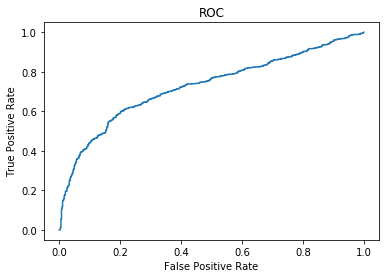

In [30]:
#ROC Curve
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
preds = prediction.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(x_val, y_val)